In [1]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset",
    shuffle=True,
    batch_size=32,
    image_size=(128, 128),
)

Found 10000 files belonging to 100 classes.


In [3]:
labels = dataset.class_names
labels

['Abelmoschus Esculentus (Okra)',
 'Acorus Calamus (Dlingo)',
 'Aloe Vera (Lidah Buaya)',
 'Alstonia Scholaris (Pulai)',
 'Amaranthus Spinosus (Bayam Duri)',
 'Andrographis Paniculata (Sambiloto)',
 'Annona Muricata (Sirsak)',
 'Annona Squamosa (Srikaya)',
 'Anredera Cordifolia (Binahong)',
 'Apium Graveolens (Seledri)',
 'Artocarpus Heterophyllus (Nangka Mini)',
 'Artocarpus Integer (Nangka Cempedak)',
 'Averrhoa Bilimbi (Belimbing Wuluh)',
 'Blumea Balsamifera (Sembung)',
 'Borreria Hispida (Gempur Batu)',
 'Caesalpinia Sappan L (Secang)',
 'Caladium Cicolor (Keladi)',
 'Calendula Officinalis (Marigold)',
 'Canangium Odoratum (Kenanga)',
 'Catharanthus Roseus (Tapak Dara)',
 'Celosia Cristata (Jengger Ayam)',
 'Centella Asiatica (Pegagan)',
 'Cestrum Nocturnum (Sedap Malam)',
 'Citrus Amblycarpa (Jeruk Limau)',
 'Clinalanthus Nutans (Dandang Gendis)',
 'Clitoria Ternatea (Kembang Telang)',
 'Crinum Asiaticum (Bakung Putih)',
 'Curcuma Domestica (Kunyit)',
 'Cyclea Barbata (Cincau Hij

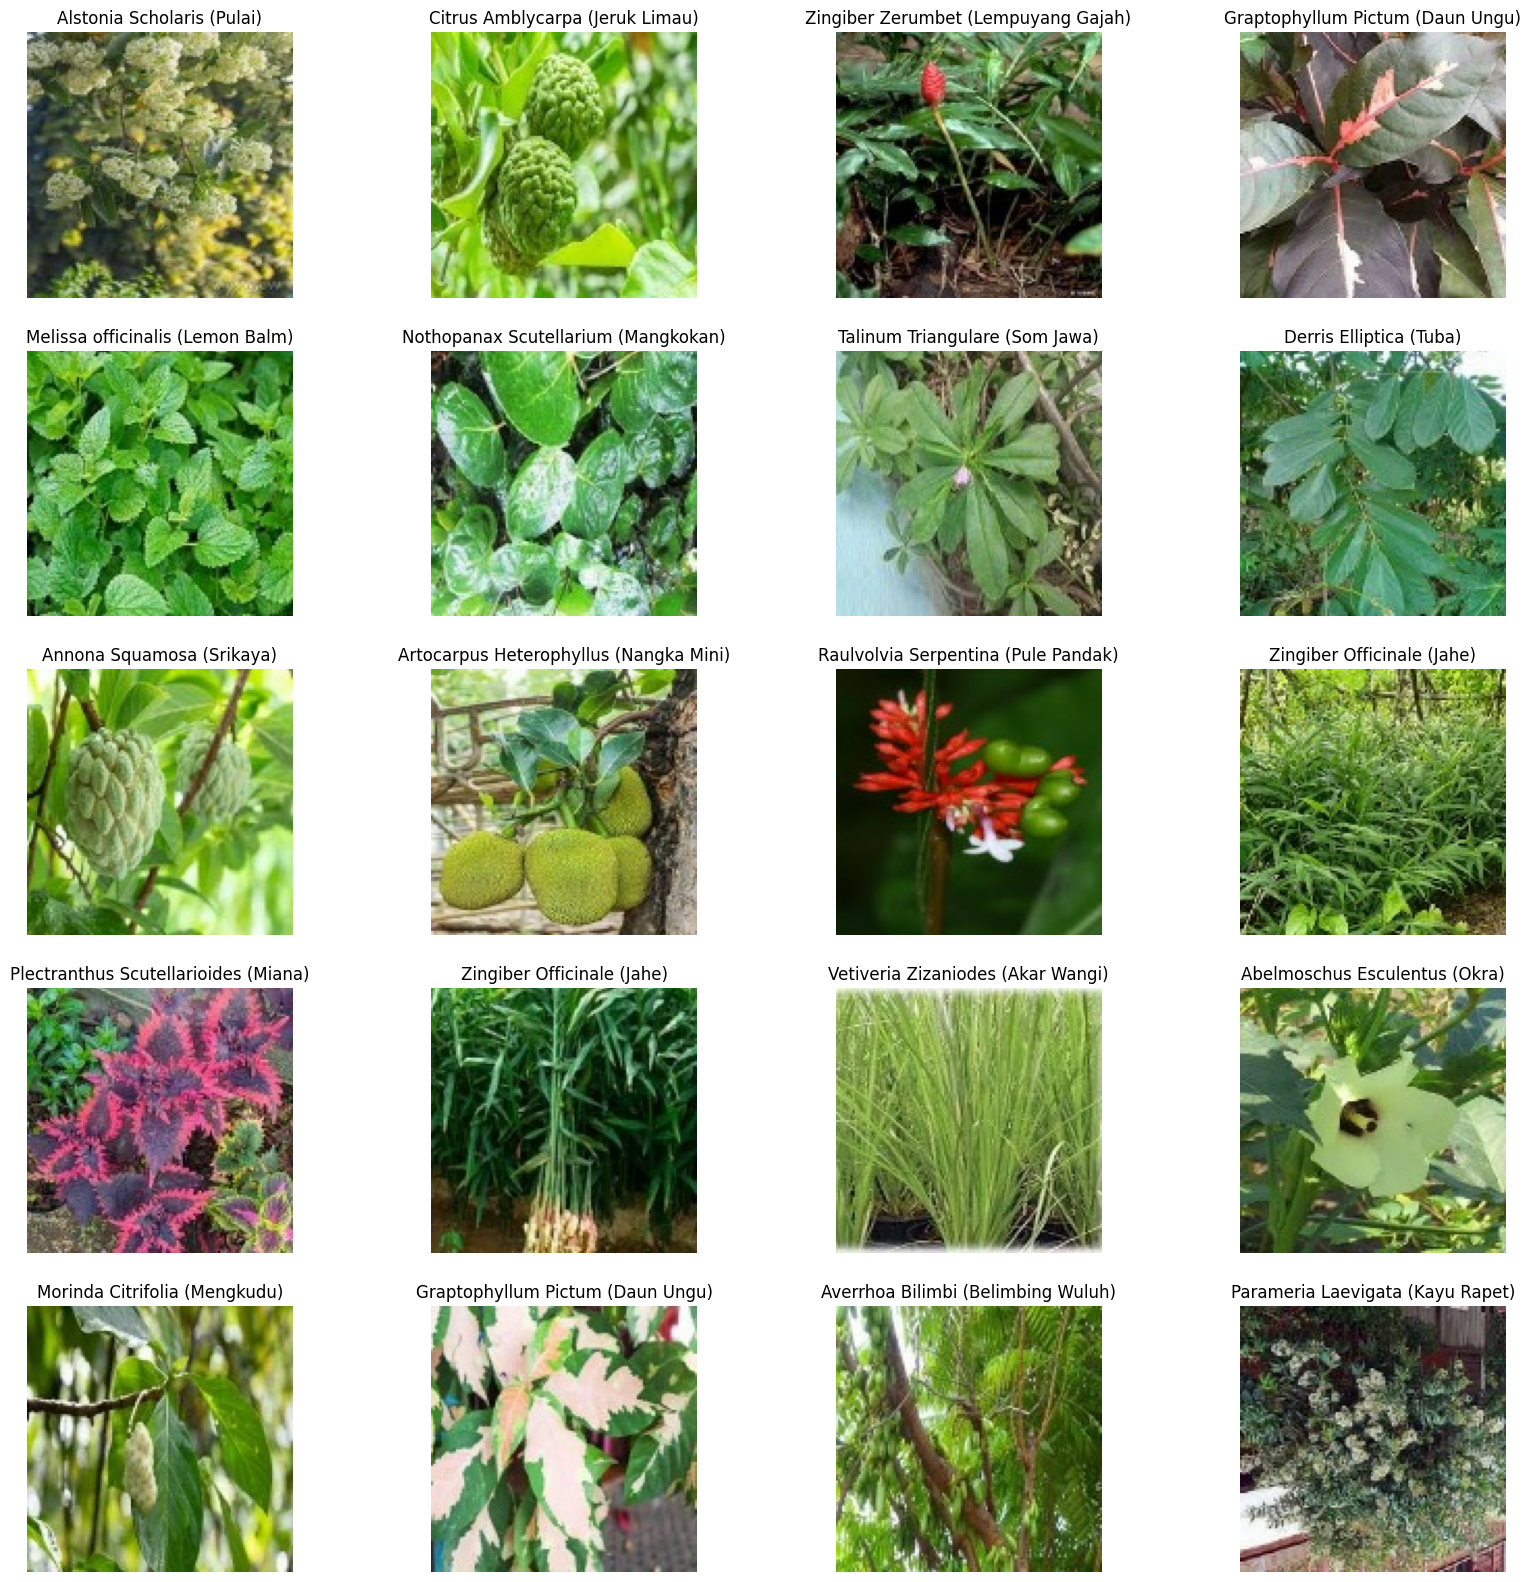

In [15]:
import matplotlib.pyplot as plt

class_names = dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)  # 5 rows, 4 columns
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [4]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 128, 128, 3)
[20 84 27 31 24 47 58 88 39 35 19 27 95  0 25 61 16 99 43 71  1 50 61  8
 91 31 73 81 87 70 69 29]


In [5]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
#     assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(219, 63, 31)

In [7]:
rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [8]:
from tensorflow.keras import regularizers


# train using InceptionV3
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

base_model.trainable = False


inputs = tf.keras.Input(shape=(128, 128, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)  # Assuming rescale is supposed to be rescaling the input
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)  # Flatten layer added
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping]
)

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                              

In [9]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 [==============================] - 6s 26ms/step - loss: 0.1667 - accuracy: 0.9886
Test Loss: 0.1667
Test Accuracy: 0.9886


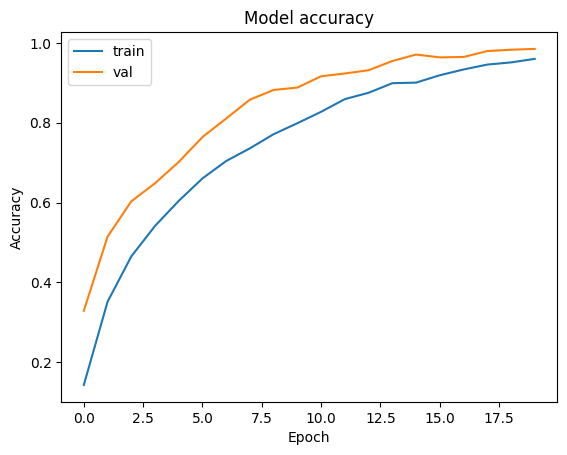

In [11]:
# plot accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

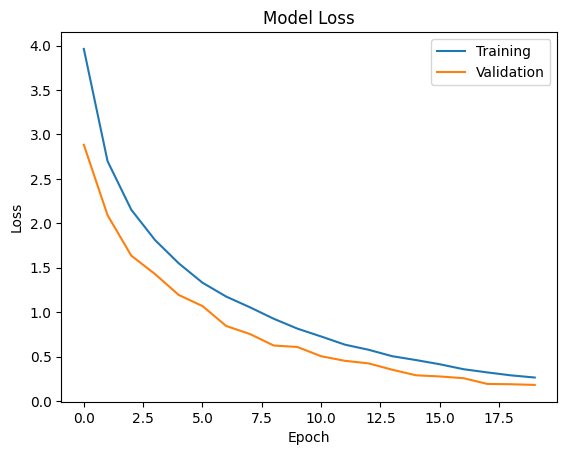

In [12]:
#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input

1/1 [==============================] - 0s 29ms/step


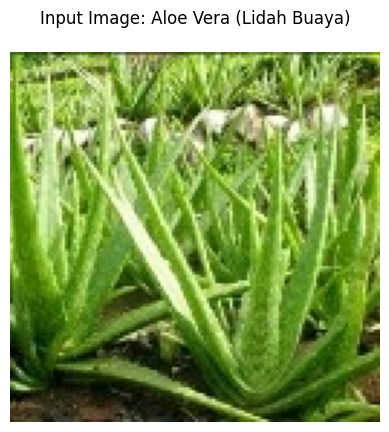

The image belongs to Aloe Vera (Lidah Buaya)


In [15]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Aloe Vera (Lidah Buaya)/77.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 30ms/step


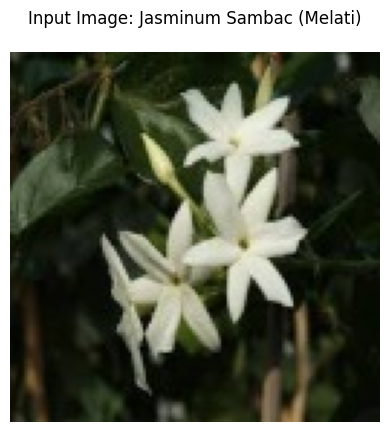

The image belongs to Jasminum Sambac (Melati)


In [27]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Jasminum Sambac (Melati)/100.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 27ms/step


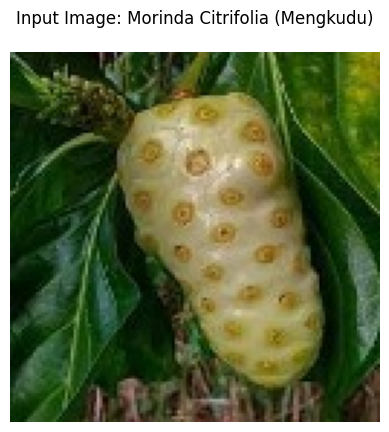

The image belongs to Morinda Citrifolia (Mengkudu)


In [30]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Morinda Citrifolia (Mengkudu)/52.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 29ms/step


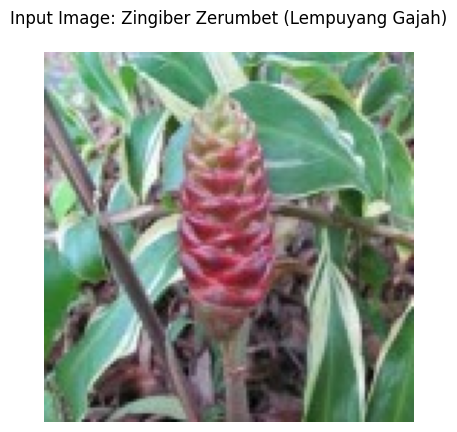

The image belongs to Zingiber Zerumbet (Lempuyang Gajah)


In [18]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Zingiber Zerumbet (Lempuyang Gajah)/75.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 28ms/step


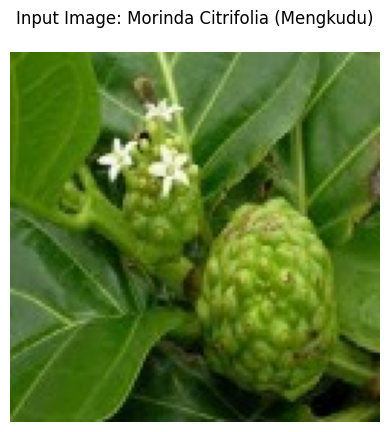

The image belongs to Morinda Citrifolia (Mengkudu)


In [19]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Morinda Citrifolia (Mengkudu)/62.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 110ms/step


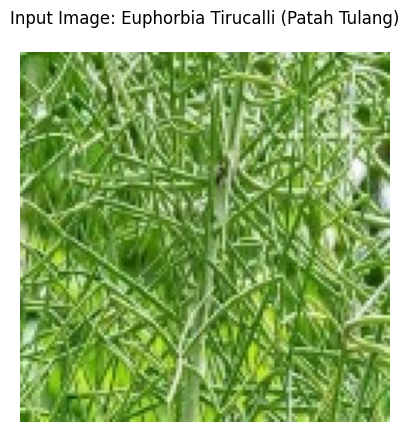

The image belongs to Euphorbia Tirucalli (Patah Tulang)


In [20]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Euphorbia Tirucalli (Patah Tulang)/2.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
print(f"The image belongs to {predicted_class}")

1/1 [==============================] - 0s 27ms/step


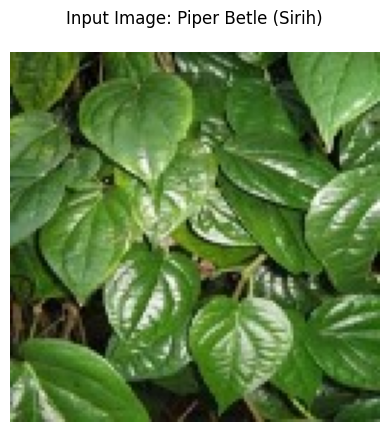

The image belongs to Piper Betle (Sirih)


In [21]:
# Load an image
img_path = '/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset/Piper Betle (Sirih)/20.jpg'
img_name = os.path.basename(os.path.dirname(img_path))  
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f"Input Image: {img_name}\n")
plt.axis('off')
plt.show()

# Display the prediction
print(f"The image belongs to {predicted_class}")

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the test set
y_true = []
y_pred = []

for images, labels_batch in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate additional evaluation metrics
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=labels)
acc_score = accuracy_score(y_true, y_pred)
rec_score = recall_score(y_true, y_pred, average='macro')
prec_score = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

63/63 [==============================] - 5s 26ms/step - loss: 0.1759 - accuracy: 0.9881
Test Loss: 0.1759
Test Accuracy: 0.9881
1/1 [==============================] - 0s 30ms/step


In [23]:
# Display the additional metrics
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[26  0  0 ...  0  0  0]
 [ 0 19  0 ...  0  1  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 23  0]
 [ 0  0  0 ...  0  0 25]]


In [24]:
print("\nClassification Report:")
print(class_report)


Classification Report:
                                              precision    recall  f1-score   support

               Abelmoschus Esculentus (Okra)       1.00      1.00      1.00        26
                     Acorus Calamus (Dlingo)       0.95      0.95      0.95        20
                     Aloe Vera (Lidah Buaya)       1.00      1.00      1.00        18
                  Alstonia Scholaris (Pulai)       1.00      1.00      1.00        16
            Amaranthus Spinosus (Bayam Duri)       1.00      0.95      0.97        20
         Andrographis Paniculata (Sambiloto)       0.96      1.00      0.98        27
                    Annona Muricata (Sirsak)       1.00      1.00      1.00        21
                   Annona Squamosa (Srikaya)       1.00      1.00      1.00        22
              Anredera Cordifolia (Binahong)       1.00      1.00      1.00        20
                  Apium Graveolens (Seledri)       1.00      1.00      1.00        26
      Artocarpus Heterophyllu

In [25]:
print("\nAccuracy Score:", acc_score)
print("Recall Score:", rec_score)
print("Precision Score:", prec_score)
print("F1 Score:", f1)


Accuracy Score: 0.9890873015873016
Recall Score: 0.9892665388007593
Precision Score: 0.9886814925563411
F1 Score: 0.9887507660416618


In [26]:
model.save('/kaggle/working/final_model.keras')

In [31]:
model.save('/kaggle/working/final_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step


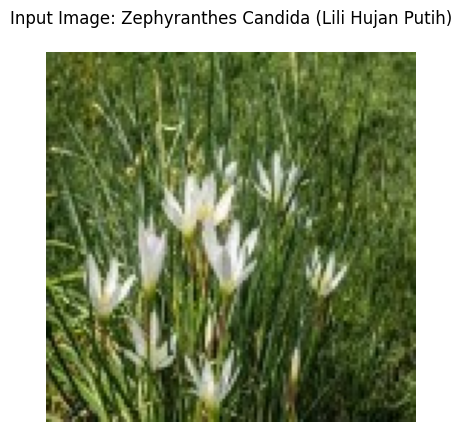

The image belongs to Zephyranthes Candida (Lili Hujan Putih)
1/1 [==============================] - 0s 28ms/step


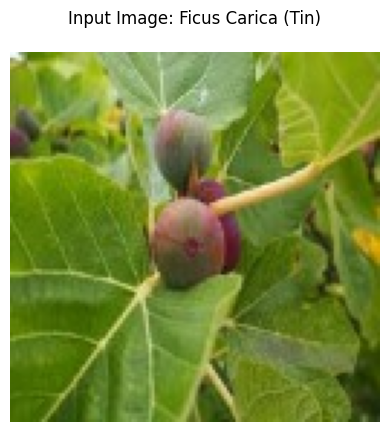

The image belongs to Ficus Carica (Tin)
1/1 [==============================] - 0s 28ms/step


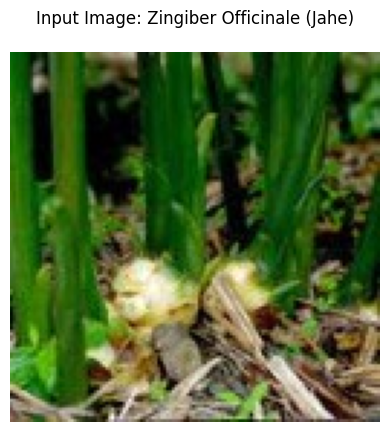

The image belongs to Zingiber Officinale (Jahe)
1/1 [==============================] - 0s 29ms/step


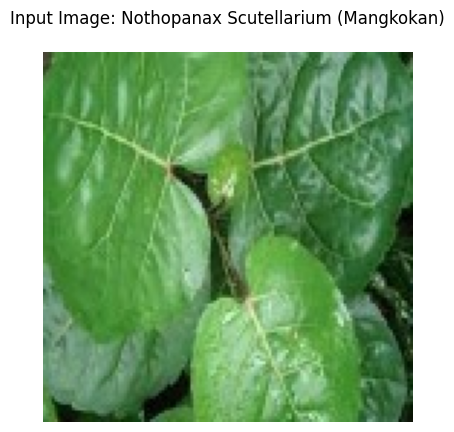

The image belongs to Nothopanax Scutellarium (Mangkokan)
1/1 [==============================] - 0s 28ms/step


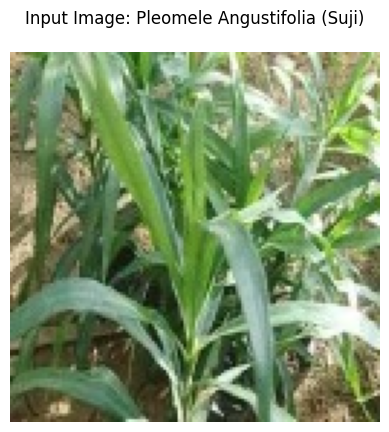

The image belongs to Pleomele Angustifolia (Suji)


In [33]:
import random
import glob
# Function to randomly select five images from the dataset
def get_random_images(dataset_path, num_images=5):
    all_images = glob.glob(os.path.join(dataset_path, '*/*.jpg'))
    random_images = random.sample(all_images, num_images)
    return random_images

# Load and predict for random images
random_images = get_random_images('/kaggle/input/indoherb/Indonesia-Medicinal-Plant-Dataset')

for img_path in random_images:
    img_name = os.path.basename(os.path.dirname(img_path))  
    img = load_img(img_path, target_size=(128, 128))  
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = labels[predicted_class_index]

    # Display the input image
    plt.imshow(img)
    plt.title(f"Input Image: {img_name}\n")
    plt.axis('off')
    plt.show()

    # Display the prediction
    print(f"The image belongs to {predicted_class}")
